# Prévia do notebook

- Obtendo os leads mais aderentes em relação a um portfólio de clientes por meio da similaridade



# Considerações do projeto

- Todos os ids estão contidos na tabela de market.
- Qual a probabilidade de uma empresa se tornar cliente.
- Abordagem a ser tomada é de similaridade entre os clientes
- O algoritmo utilizado Nearest Neighbors.

# Inicialização

Google Colab

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = '/content/drive/My Drive/LINGUAGENS/PYTHON/10 - Codenation - Data Science/desafio_final/'

### Jupyter notebook local

In [0]:
# import os
# DIR_NAME = os.path.abspath('.')
# path = DIR_NAME + '/'

In [0]:
# path

## Perguntas referentes aos Leads

- Este cliente deixou algum contato?
- Ele tem algo em comum com os nossos clientes?
- Ele tem alguma característica que vai de encontro com nossa visão de empresa?
- Ele é cliente de alguma empresa similar a nossa?

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler, LabelEncoder,
)
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

%matplotlib inline

Após pré-análise devido alta quantidade de dados faltantes, foram escolhidas as colunas que mais se adequavam ao problema.

In [0]:
cols_cat = ['id',
            'sg_uf',
            'sg_uf_matriz',
            'de_ramo',
            'setor',
            'nm_segmento',
            'nm_divisao',
            'de_saude_rescencia',
            'fl_email',
            'fl_telefone',
            'de_natureza_juridica',
            'de_nivel_atividade',
            'de_saude_tributaria',
            'de_faixa_faturamento_estimado'
           ] 

cols_num = ['nu_meses_rescencia',
            'idade_empresa_anos'
           ]

In [0]:
df_market = pd.read_csv(path + 'estaticos_market.csv', usecols= (cols_cat + cols_num))
df_port1 = pd.read_csv(path + 'estaticos_portfolio1.csv', usecols=['id'])
df_port2 = pd.read_csv(path + 'estaticos_portfolio2.csv', usecols=['id'])
df_port3 = pd.read_csv(path + 'estaticos_portfolio3.csv', usecols=['id'])

# Análise e exploração dos dados

In [0]:
df_market.head()

,id,de_natureza_juridica,sg_uf,de_ramo,setor,idade_empresa_anos,fl_email,fl_telefone,nm_divisao,nm_segmento,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,nu_meses_rescencia,de_nivel_atividade,de_faixa_faturamento_estimado
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,SOCIEDADE EMPRESARIA LIMITADA,RN,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,True,True,CONSTRUCAO DE EDIFICIOS,CONSTRUCAO,RN,VERDE,ACIMA DE 1 ANO,23.0,ALTA,"DE R$ 1.500.000,01 A R$ 4.800.000,00"
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,EMPRESARIO INDIVIDUAL,PI,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,True,True,ALIMENTACAO,ALOJAMENTO E ALIMENTACAO,PI,CINZA,ATE 1 ANO,9.0,BAIXA,"DE R$ 81.000,01 A R$ 360.000,00"
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,EMPRESARIO INDIVIDUAL,AM,"TRANSPORTE, ARMAZENAGEM E CORREIO",SERVIÇO,7.093151,False,True,TRANSPORTE TERRESTRE,TRANSPORTE ARMAZENAGEM E CORREIO,AM,AMARELO,ACIMA DE 1 ANO,26.0,MEDIA,"ATE R$ 81.000,00"
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,EMPRESARIO INDIVIDUAL,AM,SERVICOS DIVERSOS,SERVIÇO,6.512329,True,True,REPARACAO E MANUTENCAO DE EQUIPAMENTOS DE INFO...,OUTRAS ATIVIDADES DE SERVICOS,AM,AMARELO,ACIMA DE 1 ANO,26.0,MEDIA,"DE R$ 81.000,01 A R$ 360.000,00"
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,EMPRESARIO INDIVIDUAL,RN,"SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",SERVIÇO,3.200000,True,True,SERVICOS DE ARQUITETURA E ENGENHARIA TESTES E ...,ATIVIDADES PROFISSIONAIS CIENTIFICAS E TECNICAS,RN,VERDE,ACIMA DE 1 ANO,27.0,ALTA,"DE R$ 81.000,01 A R$ 360.000,00"


In [0]:
print('shape mercado: ', df_market.shape)
print('shape mercado: ', df_port1.shape)
print('shape mercado: ', df_port2.shape)
print('shape mercado: ', df_port3.shape)

shape mercado:  (462298, 16)
shape mercado:  (555, 1)
shape mercado:  (566, 1)
shape mercado:  (265, 1)


In [0]:
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462298 entries, 0 to 462297
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id                             462298 non-null  object 
 1   de_natureza_juridica           462298 non-null  object 
 2   sg_uf                          462298 non-null  object 
 3   de_ramo                        462298 non-null  object 
 4   setor                          460371 non-null  object 
 5   idade_empresa_anos             462298 non-null  float64
 6   fl_email                       462298 non-null  bool   
 7   fl_telefone                    462298 non-null  bool   
 8   nm_divisao                     460371 non-null  object 
 9   nm_segmento                    460371 non-null  object 
 10  sg_uf_matriz                   460359 non-null  object 
 11  de_saude_tributaria            447447 non-null  object 
 12  de_saude_rescencia            

In [0]:
df_market.describe()

,idade_empresa_anos,nu_meses_rescencia
count,462298.000000,417022.000000
mean,9.948677,25.007247
std,9.615664,9.679799
min,0.016438,0.000000
25%,2.756164,22.000000
50%,6.704110,23.000000
75%,14.465753,25.000000
max,106.432877,66.000000


# Pré-processamento

## Missing values

In [0]:
df_market.isna().sum()

id                                   0
de_natureza_juridica                 0
sg_uf                                0
de_ramo                              0
setor                             1927
idade_empresa_anos                   0
fl_email                             0
fl_telefone                          0
nm_divisao                        1927
nm_segmento                       1927
sg_uf_matriz                      1939
de_saude_tributaria              14851
de_saude_rescencia               14851
nu_meses_rescencia               45276
de_nivel_atividade               11168
de_faixa_faturamento_estimado    27513
dtype: int64

In [0]:
df_market.isna().mean() * 100

id                               0.000000
de_natureza_juridica             0.000000
sg_uf                            0.000000
de_ramo                          0.000000
setor                            0.416831
idade_empresa_anos               0.000000
fl_email                         0.000000
fl_telefone                      0.000000
nm_divisao                       0.416831
nm_segmento                      0.416831
sg_uf_matriz                     0.419426
de_saude_tributaria              3.212430
de_saude_rescencia               3.212430
nu_meses_rescencia               9.793683
de_nivel_atividade               2.415758
de_faixa_faturamento_estimado    5.951356
dtype: float64

### Tratamento de missing values

In [0]:
df_market.dropna(subset=['setor', 'nm_divisao', 'nm_segmento', 'sg_uf_matriz'], inplace= True)

**Momento em que deu certo atribuir um preenchimento um pouco mais robusto**

In [0]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://media.giphy.com/media/cgRTVEIKVX8AM/giphy.gif")

**Missing values de_nivel_atividade**

In [0]:
segmentos = df_market.loc[df_market['de_nivel_atividade'].isnull()]['nm_divisao'].unique()
dic_atividade = {}
for segmento in segmentos:
    temp = df_market.loc[df_market['nm_divisao'] == segmento, 'de_nivel_atividade'].mode()[0]
    dic_atividade.update({segmento: temp})

In [0]:
for segmento in segmentos:
    temp = dic_atividade[segmento]
    df_market.loc[(df_market['de_nivel_atividade'].isnull()) & (df_market['nm_divisao'] == segmento), 'de_nivel_atividade'] = temp

**Missing values de_saude_tributaria**

In [0]:
segmentos = df_market.loc[df_market['de_saude_tributaria'].isnull()]['nm_divisao'].unique()
dic_trib = {}
for segmento in segmentos:
    temp = df_market.loc[df_market['nm_divisao'] == segmento, 'de_saude_tributaria'].mode()[0]
    dic_trib.update({segmento: temp})

In [0]:
for segmento in segmentos:
    temp = dic_trib[segmento]
    df_market.loc[(df_market['de_saude_tributaria'].isnull()) & (df_market['nm_divisao'] == segmento), 'de_saude_tributaria'] = temp

**Missing values de_faixa_faturamento_estimado**

In [0]:
segmentos = df_market.loc[df_market['de_faixa_faturamento_estimado'].isnull()]['nm_divisao'].unique()
dic_fat = {}
for segmento in segmentos:
    temp = df_market.loc[df_market['nm_divisao'] == segmento, 'de_faixa_faturamento_estimado'].mode()[0]
    dic_fat.update({segmento: temp})

In [0]:
for segmento in segmentos:
    temp = dic_fat[segmento]
    df_market.loc[(df_market['de_faixa_faturamento_estimado'].isnull()) & (df_market['nm_divisao'] == segmento), 'de_faixa_faturamento_estimado'] = temp

**Missing values de_saude_rescencia**

In [0]:
segmentos = df_market.loc[df_market['de_saude_rescencia'].isnull()]['nm_divisao'].unique()
dic_resc = {}
for segmento in segmentos:
    temp = df_market.loc[df_market['nm_divisao'] == segmento, 'de_saude_rescencia'].mode()[0]
    dic_resc.update({segmento: temp})

In [0]:
for segmento in segmentos:
    temp = dic_resc[segmento]
    df_market.loc[(df_market['de_saude_rescencia'].isnull()) & (df_market['nm_divisao'] == segmento), 'de_saude_rescencia'] = temp

**Missing values nu_meses_rescencia**

In [0]:
df_market['nu_meses_rescencia'].fillna(int(df_market['nu_meses_rescencia'].mean()), inplace= True)

Após os dados tratados

In [0]:
df_market.isnull().sum()

id                               0
de_natureza_juridica             0
sg_uf                            0
de_ramo                          0
setor                            0
idade_empresa_anos               0
fl_email                         0
fl_telefone                      0
nm_divisao                       0
nm_segmento                      0
sg_uf_matriz                     0
de_saude_tributaria              0
de_saude_rescencia               0
nu_meses_rescencia               0
de_nivel_atividade               0
de_faixa_faturamento_estimado    0
dtype: int64

## Encoder

Após análise foram decididos por usar essas features para clustering dos dados

In [0]:
cols_nominal = ['id',
                'sg_uf',
                'de_ramo',
                'de_natureza_juridica',
               ] 

cols_ordinal = ['de_nivel_atividade',
                'de_saude_tributaria', 
                'de_faixa_faturamento_estimado']
                
cols_nominal_bin = ['fl_email',
                    'fl_telefone']
                
cols_numeric = ['idade_empresa_anos']

- **id**: Código de identificação da empresa
- **sg_uf**: Sigla do estado em que a empresa pertence
- **de_ramo**: Descrição de uma categoria / ramificação de atividade de macro com base no código CNAE
- **de_natureza_juridica**: Natureza jurídica da empresa
- **de_nivel_atividade**: probabilidade de estar em operação 
- **de_saude_tributaria**: status do imposto sobre saúde, Verde se todos os impostos estiverem OK, Vermelho se nenhum estiver OK
- **de_faixa_faturamento_estimado**: Classe da receita estimada da empresa
- **fl_email**: True se o cnpj tiver um email registrado no banco de dados do IRF
- **fl_telefone**: True se o cnpj tiver um telefone registrado no banco de dados do IRF
- **idade_empresa_anos**: Idade da empresa em anos

**Label Encoder**

In [0]:
label = LabelEncoder()
df_train = pd.DataFrame(data=df_market['id'])
df_train[cols_numeric] = df_market[cols_numeric].copy()

cols = cols_ordinal + cols_nominal_bin
for col in cols:
    df_train[col] = label.fit_transform(df_market[col])

In [0]:
df_train.head()

,id,idade_empresa_anos,de_nivel_atividade,de_saude_tributaria,de_faixa_faturamento_estimado,fl_email,fl_telefone
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,14.457534,0,4,2,1,1
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,1.463014,1,2,10,1,1
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,7.093151,2,0,1,0,1
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,6.512329,2,0,10,1,1
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,3.200000,0,4,10,1,1


**Normalização dos dados**

In [0]:
scaler = StandardScaler()

In [0]:
features_scaler = cols_ordinal + cols_numeric

In [0]:
scaler.fit(df_train[features_scaler])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
df_train.reset_index(drop= True, inplace= True)

In [0]:
df_train[features_scaler] = pd.DataFrame(data= scaler.transform(df_train[features_scaler]), columns= features_scaler)

In [0]:
df_train.head()

,id,idade_empresa_anos,de_nivel_atividade,de_saude_tributaria,de_faixa_faturamento_estimado,fl_email,fl_telefone
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,0.485099,-1.291172,1.151656,-1.467388,1,1
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,-0.882338,-0.196314,-0.100016,0.663398,1,1
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,-0.289868,0.898544,-1.351689,-1.733737,0,1
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,-0.350989,0.898544,-1.351689,0.663398,1,1
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,-0.699552,-1.291172,1.151656,0.663398,1,1


**One Hot Encoder**

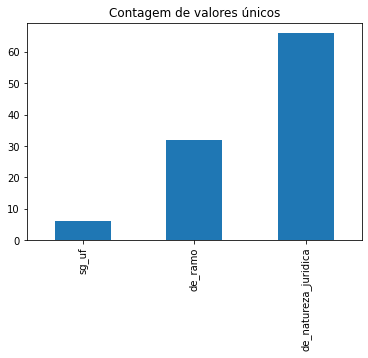

In [0]:
# features = df_market.drop('id', axis=1).columns
df_market[cols_nominal[1:]].nunique().plot(kind='bar')
plt.title('Contagem de valores únicos');

In [0]:
onehot = OneHotEncoder(sparse= False, handle_unknown= 'ignore')
onehot.fit(df_market[cols_nominal[1:]])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=False)

In [0]:
features_one = onehot.get_feature_names(cols_nominal[1:])

In [0]:
onehot_df = pd.DataFrame( onehot.transform(df_market[cols_nominal[1:]]), columns= features_one)

In [0]:
df_train.reset_index(drop= True, inplace= True)

In [0]:
df_train = pd.concat([df_train, onehot_df.copy()], axis=1)

In [0]:
del(onehot_df)

In [0]:
df_train

,id,idade_empresa_anos,de_nivel_atividade,de_saude_tributaria,de_faixa_faturamento_estimado,fl_email,fl_telefone,sg_uf_AC,sg_uf_AM,sg_uf_MA,sg_uf_PI,sg_uf_RN,sg_uf_RO,"de_ramo_ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",de_ramo_ATIVIDADES IMOBILIARIAS,de_ramo_BENS DE CONSUMO,de_ramo_COMERCIO E REPARACAO DE VEICULOS,de_ramo_COMERCIO POR ATACADO,de_ramo_COMERCIO VAREJISTA,"de_ramo_CULTURA, ESPORTE E RECREACAO",de_ramo_ELETRICIDADE E GAS,de_ramo_ELETROELETRONICOS,de_ramo_FARMACEUTICA,de_ramo_INDUSTRIA AUTOMOTIVA,de_ramo_INDUSTRIA DA CONSTRUCAO,de_ramo_INDUSTRIA DIGITAL,de_ramo_INDUSTRIAS EXTRATIVAS,de_ramo_ORGANISMOS INTERNACIONAIS,de_ramo_PAPEL E CELULOSE,de_ramo_PRODUTOS DE AGROPECUARIA,de_ramo_QUIMICA-PETROQUIMICA,"de_ramo_SEGUROS, PLANOS DE PREVIDENCIA E PLANOS DE SAUDE",de_ramo_SERVICOS ADMINISTRATIVOS,de_ramo_SERVICOS DE ALOJAMENTO/ALIMENTACAO,de_ramo_SERVICOS DE EDUCACAO,de_ramo_SERVICOS DE SANEAMENTO BASICO,de_ramo_SERVICOS DE SAUDE,de_ramo_SERVICOS DIVERSOS,de_ramo_SERVICOS FINANCEIROS,"de_ramo_SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",...,de_natureza_juridica_FUNDACAO PUBLICA DE DIREITO PRIVADO FEFERAL,de_natureza_juridica_FUNDACAO PUBLICA DE DIREITO PRIVADO MUNICIPAL,de_natureza_juridica_FUNDACAO PUBLICA DE DIREITO PUB MUNICIPAL,de_natureza_juridica_FUNDACAO PUBLICA DE DIREITO PUBFEDERAL,de_natureza_juridica_FUNDO PRIVADO,de_natureza_juridica_FUNDO PUBLICO,de_natureza_juridica_GRUPO DE SOCIEDADES,de_natureza_juridica_MUNICIPIO,de_natureza_juridica_ORGANIZACAO RELIGIOSA,de_natureza_juridica_ORGANIZACAO SOCIAL OS,de_natureza_juridica_ORGAO DE DIRECAO LOCAL DE PARTIDO POLITICO,de_natureza_juridica_ORGAO DE DIRECAO NACIONAL DE PARTIDO POLITICO,de_natureza_juridica_ORGAO DE DIRECAO REGIONAL DE PARTIDO POLITICO,de_natureza_juridica_ORGAO PUBLICO AUTONOMO ESTADUAL OU DO DISTRITO FEDERAL,de_natureza_juridica_ORGAO PUBLICO AUTONOMO MUNICIPAL,de_natureza_juridica_ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU DO DISTRITO FEDERAL,de_natureza_juridica_ORGAO PUBLICO DO PODER EXECUTIVO FEDERAL,de_natureza_juridica_ORGAO PUBLICO DO PODER EXECUTIVO MUNICIPAL,de_natureza_juridica_ORGAO PUBLICO DO PODER JUDICIARIO ESTADUAL,de_natureza_juridica_ORGAO PUBLICO DO PODER JUDICIARIO FEDERAL,de_natureza_juridica_ORGAO PUBLICO DO PODER LEGISLATIVO ESTADUAL OU DO DISTRITO FEDERAL,de_natureza_juridica_ORGAO PUBLICO DO PODER LEGISLATIVO FEDERAL,de_natureza_juridica_ORGAO PUBLICO DO PODER LEGISLATIVO MUNICIPAL,de_natureza_juridica_REPRESENTACAO DIPLOMATICA ESTRANGEIRA,de_natureza_juridica_SERVICO NOTARIAL E REGISTRAL CARTORIO,de_natureza_juridica_SERVICO SOCIAL AUTONOMO,de_natureza_juridica_SOCIEDADE ANONIMA ABERTA,de_natureza_juridica_SOCIEDADE ANONIMA FECHADA,de_natureza_juridica_SOCIEDADE DE ECONOMIA MISTA,de_natureza_juridica_SOCIEDADE EM CONTA DE PARTICIPACAO,de_natureza_juridica_SOCIEDADE EMPRESARIA EM COMANDITA POR ACOES,de_natureza_juridica_SOCIEDADE EMPRESARIA EM COMANDITA SIMPLES,de_natureza_juridica_SOCIEDADE EMPRESARIA EM NOME COLETIVO,de_natureza_juridica_SOCIEDADE EMPRESARIA LIMITADA,de_natureza_juridica_SOCIEDADE MERCANTIL DE CAPITAL E INDUSTRIA,de_natureza_juridica_SOCIEDADE SIMPLES EM COMANDITA SIMPLES,de_natureza_juridica_SOCIEDADE SIMPLES EM NOME COLETIVO,de_natureza_juridica_SOCIEDADE SIMPLES LIMITADA,de_natureza_juridica_SOCIEDADE SIMPLES PURA,de_natureza_juridica_SOCIEDADE UNIPESSOAL DE ADVOCACIA
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,0.485099,-1.291172,1.151656,-1.467388,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,-0.882338,-0.196314,-0.100016,0.663398,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.

# Machine Learning

## Nearest Neighbors

In [0]:
def lead_list(port, df_train, df_market, k):
    """
        Parametros
        ----------

        port = porfólio onde será obtido as ids mais próximas
        df_train = DataFrame onde será mapeado os elementos a serem localizados
        df_market = DataFrame do mercado para fazer o merge com as características dos leads
        k = número de vizinhos a serem localizados

        Return
        ------
        Dataframe dos Leads
    """
    
    df_correct = df_train[df_train['id'].apply(lambda x: x not in port['id'].values)]
    
    nbrs = NearestNeighbors(n_neighbors= k, metric='cosine')
    
    nbrs.fit(df_correct.drop('id', axis= 1))
    
    port_aux = df_train.merge(port, how='inner', on='id', left_index= True)
    distances, indices = nbrs.kneighbors(port_aux.drop('id', axis= 1))
    
    distances = distances.flatten()
    indices = indices.flatten()
    
    leads = pd.DataFrame({'id': df_correct.iloc[indices]['id'].copy()})
    
    del(df_correct, distances, indices)
    leads = df_market.merge(leads, how='inner', on= 'id')
    leads.drop_duplicates(subset='id', keep='first', inplace=True)
    
    return leads

# Validação e métricas

**Portfólio 1**

In [0]:
port1_train, port1_test = train_test_split(df_port1, test_size=0.2)

In [0]:
df_leads1 = lead_list(port= port1_train, df_train= df_train, df_market= df_market, k=10)

In [0]:
lead_1 = df_leads1.merge(port1_test, how='inner', on='id')

In [0]:
lead_1.shape[0]/port1_test.shape[0] * 100

2.7027027027027026

**Portfólio 2**

In [0]:
port2_train, port2_test = train_test_split(df_port2, test_size=0.2)

In [0]:
df_leads2 = lead_list(port= port2_train, df_train= df_train, df_market= df_market, k= 10)

In [0]:
lead_2 = df_leads2.merge(port2_test, on='id')

In [0]:
lead_2.shape[0]/port2_test.shape[0] * 100

64.91228070175438

**Portfólio 3**

In [0]:
port3_train, port3_test = train_test_split(df_port3, test_size=0.2)

In [0]:
df_leads3 = lead_list(port= port3_train, df_train= df_train, df_market= df_market, k= 10)

In [0]:
lead_3 = df_leads3.merge(port3_test, on='id')

In [0]:
lead_3.shape[0]/port3_test.shape[0] * 100

62.264150943396224

O resultado é um pouco assustador, mas, através de uma análise detalhada dos dados, é perceptível uma alta variabilidade das características dos clientes, gerando assim, um impecílio para o algoritmo devido a alta dispersão. Para um melhor alcance, deve-se aumentar a quantidade de K vizinhos, melhorando assim, o alcance dos dados de testes. Porém, ressalta-se que essa escolha de um K vizinho afeta diretamento o tempo de processamento do algoritmo, inviabilizando assim, a localização dos leads mais aderentes.

# Visualização dos resultados

Etapa de verificação para identificar o quanto os leads mais aderentes podem impactar em um negócio.

## Portfólio 1

In [0]:
#leads
df_lead_1 = lead_list(port=df_port1, df_train= df_train, df_market= df_market, k=2)

# portfólio
df_1 = df_market.merge(df_port1, on='id')

Quantidade de leads localizados

In [0]:
print(f'Quantidade de leads localizados: {df_lead_1.shape[0]}')
print(f"Idade média das empresas: {round(df_lead_1['idade_empresa_anos'].mean(), 2)}")

Quantidade de leads localizados: 1105
Idade média das empresas: 10.16


Distribuição pela faixa de faturamento

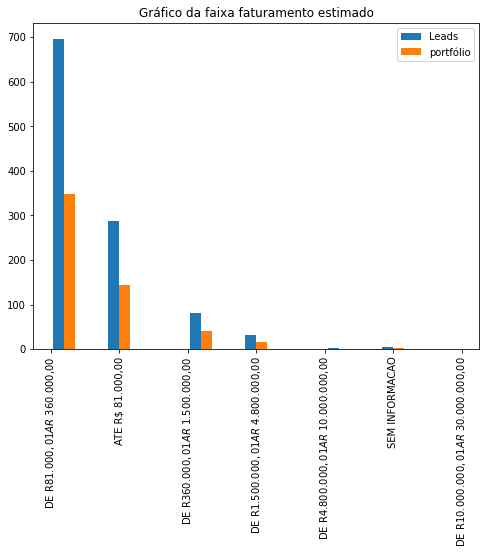

In [0]:
plt.figure(figsize=(8, 6))
plt.hist([df_lead_1['de_faixa_faturamento_estimado'], df_1['de_faixa_faturamento_estimado']],bins=15, label=['Leads', 'portfólio'])
plt.title('Gráfico da faixa faturamento estimado')
plt.xticks(rotation=90)
plt.legend();

Ao verificar-se a faixa de faturamente, é possível identificar o impacto positivo que teriam caso todos os leads tornarem-se clientes, podendo praticamente triplicar a renda.

Distruibuição da natureza jurídica

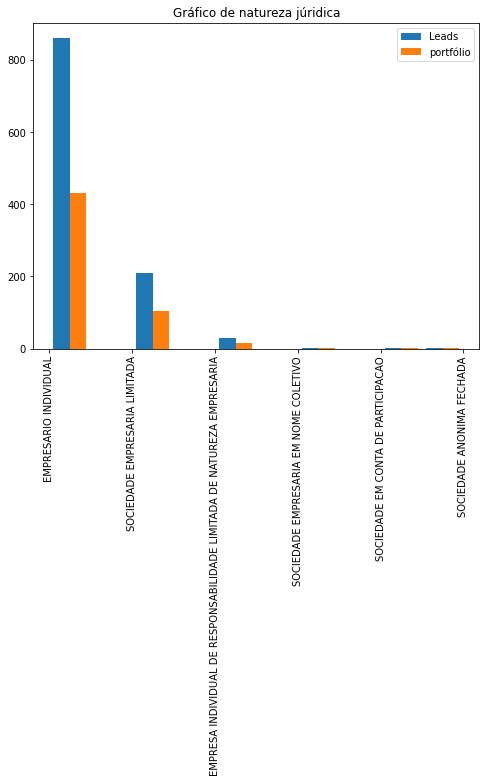

In [0]:
plt.figure(figsize=(8,6))
plt.hist([df_lead_1['de_natureza_juridica'], df_1['de_natureza_juridica']], label=['Leads', 'portfólio'])
plt.title('Gráfico de natureza júridica')
plt.xticks(rotation=90)
plt.legend();

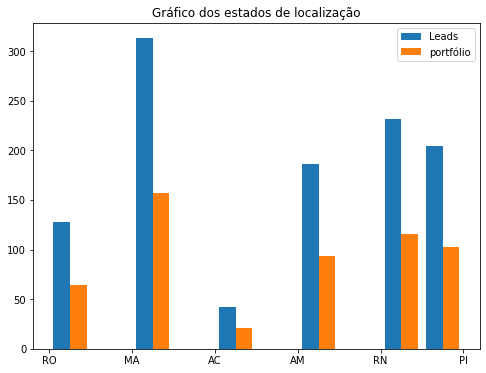

In [0]:
plt.figure(figsize=(8,6))
plt.hist([df_lead_1['sg_uf'], df_1['sg_uf']], label=['Leads', 'portfólio'])
plt.title('Gráfico dos estados de localização')
plt.legend();

Distribuição dos setores

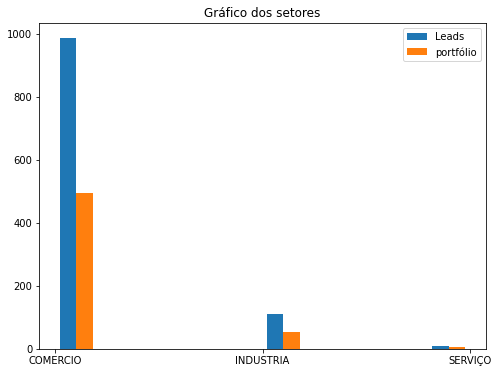

In [0]:
plt.figure(figsize=(8,6))
plt.hist([df_lead_1['setor'], df_1['setor']], label=['Leads', 'portfólio'])
plt.title('Gráfico dos setores')
plt.legend();

**Conclui-se com a análise dos gráficos que é possível identificar o quanto de valor de negócio pode ser alcançado ao conseguir identificar os leads mais aderentes, pois assim, será possível direcionar campanhas de captação de clientes para cidades onde os leads mais aderentes estão localizados, exemplificado neste portfólio como o Estado do Maranhão. Observa-se também que o setor de maior predominância é o de comércio.
Através da utilização deste tipo de análise, faz-se possível obter um melhor aproveitamento de tempo dedicado a captura de leads, pois, estes tendem a ter maior probabilidade de ser convertido em novos clientes.**

## Portfólio 2

In [0]:
#leads
df_lead_2 = lead_list(port=df_port2, df_train= df_train, df_market= df_market, k=2)

# portfólio
df_2 = df_market.merge(df_port2, on='id')

Quantidade de leads localizados

In [0]:
print(f'Quantidade de leads localizados: {df_lead_2.shape[0]}')
print(f"Idade média das empresas: {round(df_lead_2['idade_empresa_anos'].mean(), 2)}")

Quantidade de leads localizados: 937
Idade média das empresas: 25.6


Distribuição pela faixa de faturamento

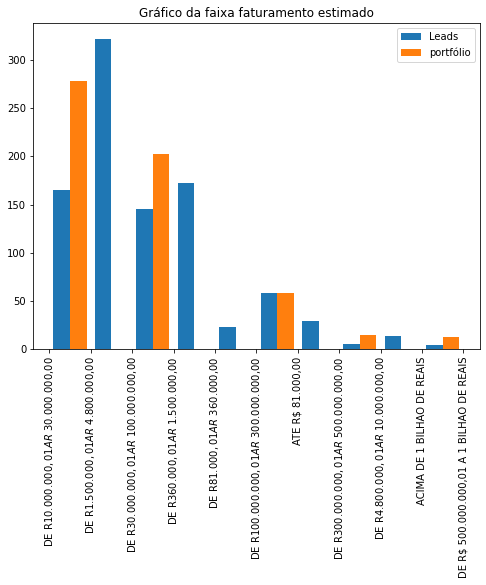

In [0]:
plt.figure(figsize=(8, 6))
plt.hist([df_lead_2['de_faixa_faturamento_estimado'], df_2['de_faixa_faturamento_estimado']], label=['Leads', 'portfólio'])
plt.title('Gráfico da faixa faturamento estimado')
plt.xticks(rotation=90)
plt.legend();

Distruibuição da natureza jurídica

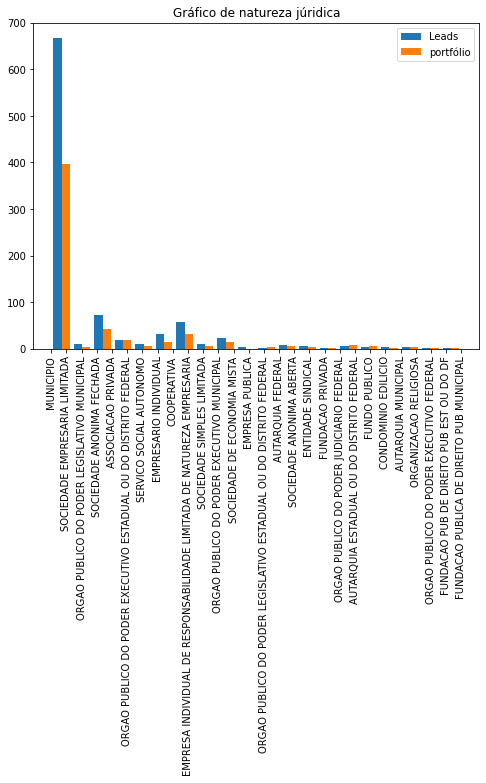

In [0]:
plt.figure(figsize=(8,6))
plt.hist([df_lead_2['de_natureza_juridica'], df_2['de_natureza_juridica']],bins=20, label=['Leads', 'portfólio'])
plt.title('Gráfico de natureza júridica')
plt.xticks(rotation=90)
plt.legend();

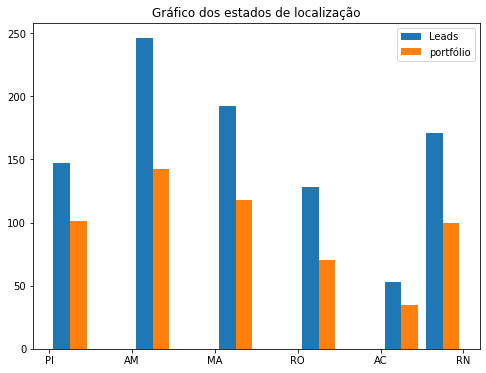

In [0]:
plt.figure(figsize=(8,6))
plt.hist([df_lead_2['sg_uf'], df_2['sg_uf']], label=['Leads', 'portfólio'])
plt.title('Gráfico dos estados de localização')
plt.legend();

Distribuição dos setores

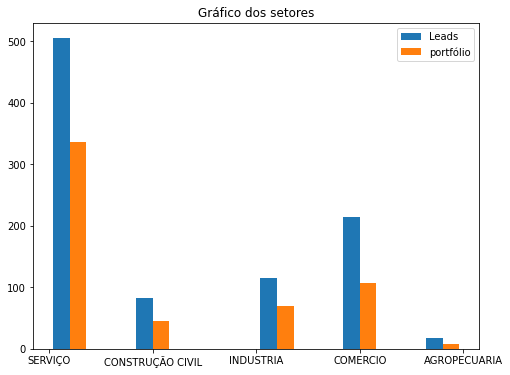

In [0]:
plt.figure(figsize=(8,6))
plt.hist([df_lead_2['setor'], df_2['setor']], label=['Leads', 'portfólio'])
plt.title('Gráfico dos setores')
plt.legend();

## Portfólio 3

In [0]:
#leads
df_lead_3 = lead_list(port=df_port3, df_train= df_train, df_market= df_market, k=2)

# portfólio
df_3 = df_market.merge(df_port3, on='id')

Quantidade de leads localizados

In [0]:
print(f'Quantidade de leads localizados: {df_lead_3.shape[0]}')
print(f"Idade média das empresas: {round(df_lead_3['idade_empresa_anos'].mean(), 2)}")

Quantidade de leads localizados: 392
Idade média das empresas: 25.34


Distribuição pela faixa de faturamento

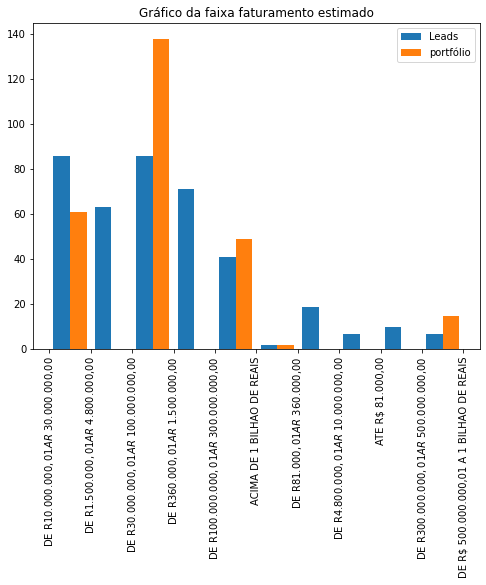

In [0]:
plt.figure(figsize=(8, 6))
plt.hist([df_lead_3['de_faixa_faturamento_estimado'], df_3['de_faixa_faturamento_estimado']], label=['Leads', 'portfólio'])
plt.title('Gráfico da faixa faturamento estimado')
plt.xticks(rotation=90)
plt.legend();

Distruibuição da natureza jurídica

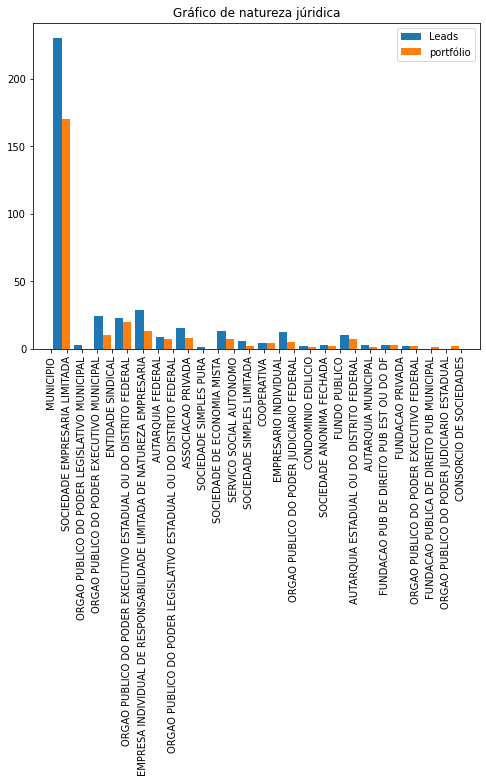

In [0]:
plt.figure(figsize=(8,6))
plt.hist([df_lead_3['de_natureza_juridica'], df_3['de_natureza_juridica']],bins=20, label=['Leads', 'portfólio'])
plt.title('Gráfico de natureza júridica')
plt.xticks(rotation=90)
plt.legend();

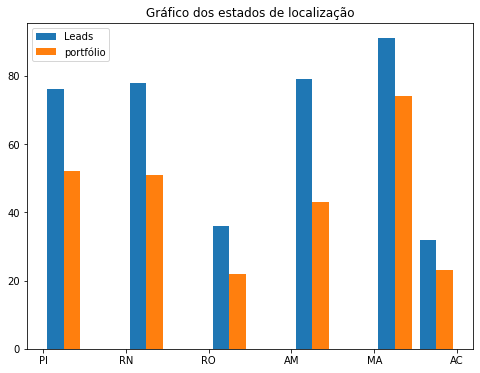

In [0]:
plt.figure(figsize=(8,6))
plt.hist([df_lead_3['sg_uf'], df_3['sg_uf']], label=['Leads', 'portfólio'])
plt.title('Gráfico dos estados de localização')
plt.legend();

Distribuição dos setores

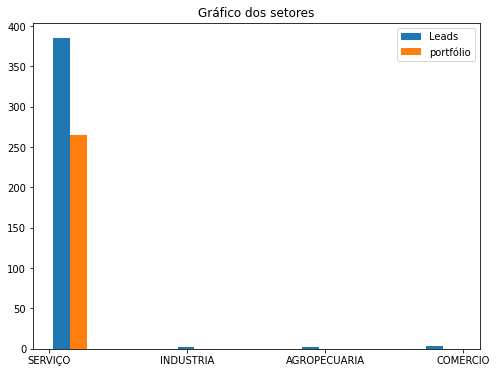

In [0]:
plt.figure(figsize=(8,6))
plt.hist([df_lead_3['setor'], df_3['setor']], label=['Leads', 'portfólio'])
plt.title('Gráfico dos setores')
plt.legend();